**Install dependencies**

In [1]:
# %%capture
# !pip install -U pillow gradio numpy pandas
# !pip install -U cjm_pil_utils

**Import dependencies**

In [4]:
import hashlib
from pathlib import Path

from PIL import Image
import numpy as np
import gradio as gr

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

In [5]:
from cjm_pil_utils.core import get_img_files

**Set path to dataset**

In [6]:
dataset_path = Path(f"./train_dir/cp2077-steelbook-custom-768")

**Set path to image folder**

In [7]:
# Set the path for the images directory
img_dir = Path(dataset_path/"images/")

**Get image paths**

In [8]:
# Get a list of the paths to the images in the images directory
img_paths = get_img_files(img_dir)

# Print the number of images in the images directory
print(len(img_paths))

46


**View sample image**

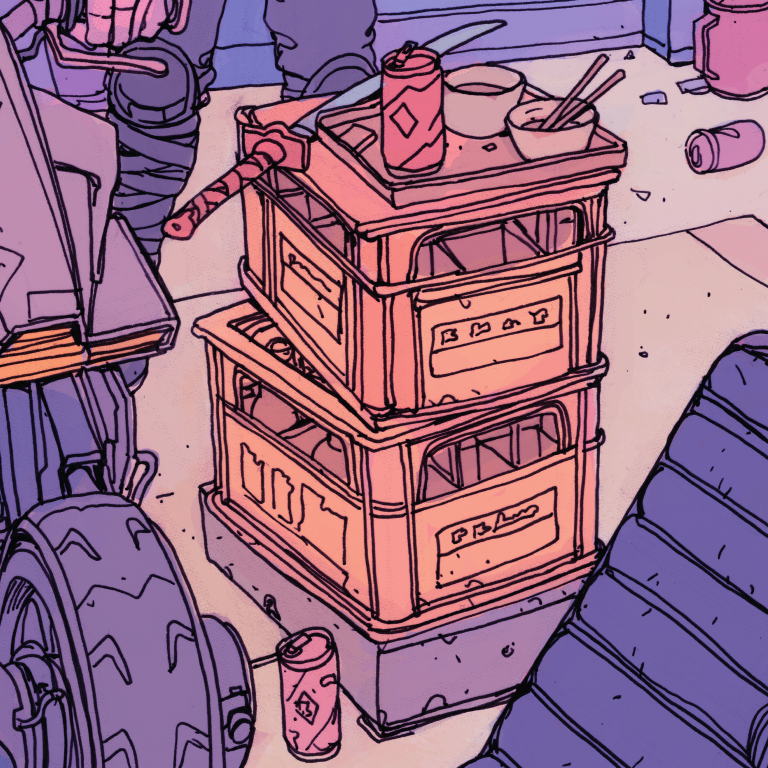

In [9]:
sample_img = Image.open(img_paths[0])
sample_img

**Map image IDs to file paths**

In [10]:
# Create a dictionary mapping image IDs to image paths
img_path_dict = {path.stem.split('-')[-1] : path for path in img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(img_path_dict, orient='index').head()

,0
24a39f42,train_dir/cp2077-steelbook-custom-768/images/tyger_claws_b1-24a39f42.png
0a07b120,train_dir/cp2077-steelbook-custom-768/images/valentinos_b1-0a07b120.png
20847e24,train_dir/cp2077-steelbook-custom-768/images/maelstrom_b1-20847e24.png
261ab67f,train_dir/cp2077-steelbook-custom-768/images/maelstrom_b1-261ab67f.png
41616c28,train_dir/cp2077-steelbook-custom-768/images/maelstrom_b1-41616c28.png


**Store list of image IDs**

In [11]:
img_ids = list(img_path_dict.keys())

**Set path for prompt DataFrame**

In [12]:
prompt_df_path = Path(dataset_path/"prompts_df.json")
prompt_df_path

PosixPath('train_dir/cp2077-steelbook-custom-768/prompts_df.json')

**Load prompt DataFrame if present**

In [13]:
if prompt_df_path.exists():
    prompt_df = pd.read_json(prompt_df_path)
else:
    # Create a list of empty strings
    data = [''] * len(img_ids)
    prompt_df = pd.DataFrame(data, index=img_ids, columns=['prompt'])

prompt_df.head()

,prompt
0a07b120,A metal rooftop sign with an arrow above the letters B O D E G A on top of a building. A man's forehead is visible at the bottom of the image.
0cfbedaa,A man wearing an eye visor kneeling on one knee while plugging a tube into the side of a chair with another man sitting on it.
1276c1a1,A low-angle view of digital cafe sign on the side of a building with graffiti on it.
20847e24,A guy wearing goggles and a tactical vest holding an inhaler in his left hand while lounging on a red couch with a sword sticking out of it.
21436daa,A short table with some candles and a skull on top of it behind a couch.


**Initialize list of images to delete**

In [14]:
marked_img_ids = []

**Initialize navigation index**

In [15]:
# Current index
index = 0

**Define functions for gradio interface**

In [16]:
# Function to go to the previous image
def prev_image():
    global index
    global prompt_df
    global marked_img_ids
    index = index - 1 if index > 0 else len(img_ids)-1
    img_id = img_ids[index]
    btn_val = "Unmark" if img_id in marked_img_ids else "Mark to Delete"
    return img_path_dict[img_ids[index]], prompt_df.loc[img_id]['prompt'], btn_val

# Function to go to the next image
def next_image():
    global index
    global prompt_df
    global marked_img_ids
    index = index + 1 if index < len(img_ids)-1 else 0
    img_id = img_ids[index]
    
    btn_val = "Unmark" if img_id in marked_img_ids else "Mark to Delete"
    return img_path_dict[img_ids[index]], prompt_df.loc[img_id]['prompt'], btn_val
    
def update_prompt(new_prompt):
    global index
    global prompt_df
    
    img_id = img_ids[index]
    prompt_df.loc[img_id]['prompt'] = new_prompt
    
def mark_to_delete():
    global index
    global marked_img_ids
    img_id = img_ids[index]
    if img_id in marked_img_ids: 
        marked_img_ids.remove(img_id)
        return "Mark to Delete"
    else:
        marked_img_ids.append(img_id)
        return "Unmark"

**Create gradio interface**

In [17]:
with gr.Blocks() as demo:
    with gr.Row():
        prev_button = gr.Button('Previous')
        next_button = gr.Button('Next')
    with gr.Row():
        mark_del_button = gr.Button('Mark to Delete')
    with gr.Row():
        prompt_textbox = gr.Textbox(label="Prompt", 
                                    value=prompt_df.loc[img_ids[index]]['prompt'], 
                                    placeholder="Enter a prompt..")
    with gr.Row():
        update_prompt_button = gr.Button('Update Prompt')

    image_output = gr.Image(img_path_dict[img_ids[index]])

    prev_button.click(prev_image, outputs=[image_output, prompt_textbox, mark_del_button])
    next_button.click(next_image, outputs=[image_output, prompt_textbox, mark_del_button])
    mark_del_button.click(mark_to_delete, outputs=[mark_del_button])
    update_prompt_button.click(update_prompt, inputs=prompt_textbox, outputs=None)
        
demo.launch(height=1600)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


**Check prompt for current image**

In [18]:
prompt_df.loc[img_ids[index]]['prompt']

'A stack of two storage crates with a sword and a serving tray of dishes and a soda can on top. The front of a motorcycle is visible on the left side of the image.'

**Remove prompts for marked images**

In [ ]:
prompt_df = prompt_df.drop(marked_img_ids)

**Delete marked images**

In [ ]:
for img_id in marked_img_ids:
    img_path_dict[img_id].unlink()

len(prompt_df)

**Save updated prompts**

In [32]:
prompt_df.to_json(prompt_df_path)